## Imports and Data Loading

In [ ]:
!pip install wordcloud xgboost tensorflow
!pip install openpyxl lxml contractions

In [2]:
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from bs4 import BeautifulSoup
import contractions

In [3]:
# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_excel('/content/drive/My Drive/Project_Corpora/train.xlsx')
test = pd.read_excel('/content/drive/My Drive/Project_Corpora/test.xlsx')
train_reviews = pd.read_excel('/content/drive/My Drive/Project_Corpora/train_reviews.xlsx')
test_reviews = pd.read_excel('/content/drive/My Drive/Project_Corpora/test_reviews.xlsx')

In [4]:
# Visual Code
train = pd.read_excel("C:/Users/andri/OneDrive/Documents/.NOVAIMS - MSc Data Science/dText Mining/TM_Project/Project Corpora/train.xlsx")
test = pd.read_excel("C:/Users/andri/OneDrive/Documents/.NOVAIMS - MSc Data Science/dText Mining/TM_Project/Project Corpora/test.xlsx")
train_reviews = pd.read_excel("C:/Users/andri/OneDrive/Documents/.NOVAIMS - MSc Data Science/dText Mining/TM_Project/Project Corpora/train_reviews.xlsx")
test_reviews = pd.read_excel("C:/Users/andri/OneDrive/Documents/.NOVAIMS - MSc Data Science/dText Mining/TM_Project/Project Corpora/test_reviews.xlsx")

## Data Exploration

_Guidelines: Analyze the corpora and provide some conclusions and visual information_

In [ ]:
print(train.head())
print(test.head())
print(train_reviews.head())
print(test_reviews.head())

   index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted  
0                Alojamento Local Registro: 20835/AL         0  
1  I am friendly host, and I will try to always b...         1  
2  I am a social person liking to communicate, re...         1  
3  Hello!_x000D_\nI m Portuguese and i love to me...         0  
4  Nous sommes une famille avec deux enfants de 1...         0  
   index                                        description  \
0      1  <b>The space</b><br />Apartment located in the...   
1      2  IMPORTANT: In response to COVID-19, this prope...   
2      3  Bright, beautiful, and spacious.

In [ ]:
print(train.describe())
print(train.info())
print(test.info())
print(train_reviews.info())
print(test_reviews.info())

             index     unlisted
count  6248.000000  6248.000000
mean   3124.500000     0.273367
std    1803.786573     0.445724
min       1.000000     0.000000
25%    1562.750000     0.000000
50%    3124.500000     0.000000
75%    4686.250000     1.000000
max    6248.000000     1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248 entries, 0 to 6247
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        6248 non-null   int64 
 1   description  6248 non-null   object
 2   host_about   6248 non-null   object
 3   unlisted     6248 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        695 non-null    int64 
 1   description  695 non-null    object
 2   host_about   695 non-null    o

In [ ]:
# Fetch word count for for top 5 and bottom 5 text in description
sorted_word_count_df = train[['description']].copy() \
                        .assign(word_count=lambda x: x['description'].apply(lambda y: len(str(y).split(" ")))) \
                        .sort_values(by='word_count', ascending=False)

top_bottom_word_count_df = pd.concat([sorted_word_count_df.head(), sorted_word_count_df.tail()])
top_bottom_word_count_df

,description,word_count
3549,The villa in Ericeira has 2 bedrooms and has c...,210
2046,Sunny apartment 10 m from beach and train stat...,205
4256,The villa in Ericeira has 3 bedrooms and has c...,204
1367,"Located in between Lisbon and Cascais, the Cas...",202
3154,This is a bright and design apartment in a new...,198
5243,<b>License number</b><br />Exempt,3
2999,<b>License number</b><br />105154/AL,3
4306,<b>License number</b><br />18235/AL,3
5769,<b>License number</b><br />45360/AL,3
5682,<b>License number</b><br />7797/AL,3


In [ ]:
# Checking for missing values
print(train.isnull().sum())
print(test.isnull().sum())
print(train_reviews.isnull().sum())
print(test_reviews.isnull().sum())

index          0
description    0
host_about     0
unlisted       0
dtype: int64
index          0
description    0
host_about     0
dtype: int64
index       0
comments    2
dtype: int64
index       0
comments    0
dtype: int64


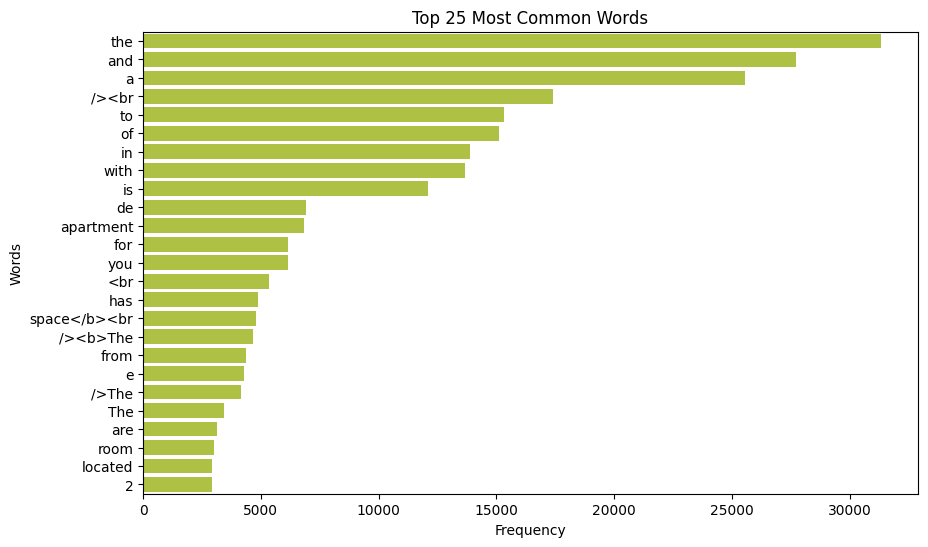

In [ ]:
# Barplot of top 25 words before preprocessing

def plot_top_n_words(corpus, n=25):
    words = [word for doc in corpus for word in doc.split()]
    word_freq = Counter(words)
    common_words = word_freq.most_common(n)
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=words, color="#bdd62f")
    plt.title(f'Top {n} Most Common Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

plot_top_n_words(train['description'])

In [ ]:
# Checking for class imbalance
print("Class Counts:",train['unlisted'].value_counts())
print("\nClass Proportions:", train['unlisted'].value_counts(normalize=True))

Class Counts: unlisted
0    4540
1    1708
Name: count, dtype: int64

Class Proportions: unlisted
0    0.726633
1    0.273367
Name: proportion, dtype: float64


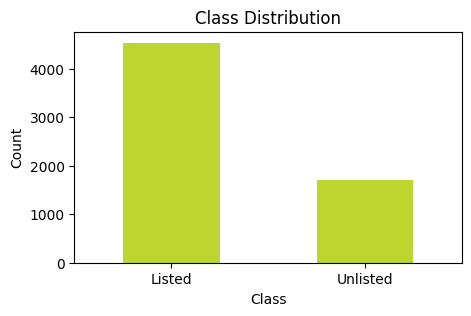

In [ ]:
# Plot the class distribution
class_counts = train['unlisted'].value_counts()
plt.figure(figsize=(5, 3))
class_counts.plot(kind='bar', color="#bdd62f")
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Listed', 'Unlisted'], rotation=0)
plt.show()

## Data Preprocessing


- Explanations in comments

#### Sentiment Analysis with VADER - EXTRA

We apply sentiment analysis on comments and then check if it has impact on target, listed or unlisted properties.

In [ ]:
!pip install vaderSentiment

In [50]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
tqdm.pandas()

train_reviews_trial = train_reviews.copy()
train_instance = train.copy()

train_reviews_trial['comments'] = train_reviews_trial['comments'].astype(str)


def predict_sentiment(text, analyzer):
  sentiment_scores = analyzer.polarity_scores(text)
  compound_score = sentiment_scores['compound']

  if compound_score >= 0.05:
      sentiment = 'Positive'
  elif compound_score <= -0.05:
      sentiment = 'Negative'
  else:
      sentiment = 'Neutral'

  return sentiment

In [51]:
analyzer = SentimentIntensityAnalyzer() # VADER sentiment analyzer

train_reviews_trial['sentiment'] = train_reviews_trial['comments'].progress_apply(lambda x: predict_sentiment(x, analyzer))

# Verify the result
train_reviews_trial.head(3)

  0%|          | 0/361281 [00:00<?, ?it/s]

100%|██████████| 361281/361281 [03:36<00:00, 1665.00it/s]


,index,comments,sentiment
0,1,this is a very cozy and comfortable house to s...,Positive
1,1,good<br/>,Neutral
2,1,"My first hostel experience, and all I have to ...",Positive


In [52]:
# Combine comments by index (index=property that the comment is about), and count the number of each sentiment for that property
## see below printed result
sentiment_counts = train_reviews_trial.groupby(['index', 'sentiment']).size().reset_index(name='count')

# attach each sentiment to a column | each row represents the property | values of table are the count (=the number of comments with that specific predicted sentiment)
## see below printed result
pivot_table = sentiment_counts.pivot_table(index='index', columns='sentiment', values='count', fill_value=0)
pivot_table = pivot_table.reset_index()
pivot_table.columns.name = None

train_instance_merged = train_instance.merge(pivot_table, how='left', left_index=True, right_on='index').reset_index().fillna(0)

In [53]:
# View the result for better understanding of the above code
sentiment_counts.head(12)

,index,sentiment,count
0,1,Negative,4
1,1,Neutral,14
2,1,Positive,32
3,5,Negative,4
4,5,Neutral,16
5,5,Positive,21
6,8,Negative,2
7,8,Neutral,14
8,8,Positive,152
9,9,Negative,5


In [54]:
# View the result for better understanding of the above code
pivot_table.head(5)

,index,Negative,Neutral,Positive
0,1,4.0,14.0,32.0
1,5,4.0,16.0,21.0
2,8,2.0,14.0,152.0
3,9,5.0,9.0,19.0
4,10,1.0,3.0,9.0


In [55]:
train_instance_merged.head(4)

,level_0,index,index_x,description,host_about,unlisted,index_y,Negative,Neutral,Positive
0,0.0,0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,0.0,0.0,0.0,0.0
1,0.0,1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,1.0,4.0,14.0,32.0
2,0.0,2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,0.0,0.0,0.0,0.0
3,0.0,3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,0.0,0.0,0.0,0.0


In [56]:
listed = train_instance_merged[train_instance_merged['unlisted'] == 0]
unlisted = train_instance_merged[train_instance_merged['unlisted'] == 1]

# Calculate the sum of values in each column
column_sums_listed = listed[['Positive', 'Neutral', 'Negative']].sum()
column_sums_unlisted = unlisted[['Positive', 'Neutral', 'Negative']].sum()

# Calculate the proportion of the sum of values in each column
proportions_listed = column_sums_listed / column_sums_listed.sum()
proportions_unlisted = column_sums_unlisted / column_sums_unlisted.sum()


print("Sentiment count and proportions of LISTED properties: ")
for sentiment_l, value_l in column_sums_listed.items():
    proportion_l = proportions_listed[sentiment_l]
    print(f"{sentiment_l}: {value_l} ({proportion_l:.2%})")

print("\nSentiment count and proportions of UNLISTED properties: ")
for sentiment_u, value_u in column_sums_unlisted.items():
    proportion_u = proportions_unlisted[sentiment_u]
    print(f"{sentiment_u}: {value_u} ({proportion_u:.2%})")

Sentiment count and proportions of LISTED properties: 
Positive: 190148.0 (72.90%)
Neutral: 48906.0 (18.75%)
Negative: 21778.0 (8.35%)

Sentiment count and proportions of UNLISTED properties: 
Positive: 73339.0 (73.21%)
Neutral: 18570.0 (18.54%)
Negative: 8265.0 (8.25%)


We will not be using the sentiment analysis in the dataset for the predictions as it does not seem to have any impact on the target, the listed and unlisted properties.

### Translation - EXTRA

#### Detect Language function

We will need this section for later use: we will compare (the run time of) the direct translation to the text vs translation in which we also take into consideration the detected lang, so when detected_lang==english we take no action.

In [5]:
!pip install langdetect

##### Checking if detect language function can understand text with 2 languages

In [6]:
from langdetect import detect

train_trial = train.head(40)
train_trial['full_text'] = train_trial['description'].fillna('') + ' ' + train_trial['host_about'].fillna('')

train_trial['detected_language'] = train_trial['full_text'].apply(lambda x: detect(x))

train_trial.head(3)

C:\Users\andri\AppData\Local\Temp\ipykernel_9160\4238871773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_trial['full_text'] = train_trial['description'].fillna('') + ' ' + train_trial['host_about'].fillna('')
C:\Users\andri\AppData\Local\Temp\ipykernel_9160\4238871773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_trial['detected_language'] = train_trial['full_text'].apply(lambda x: detect(x))


,index,description,host_about,unlisted,full_text,detected_language
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,"This is a shared mixed room in our hostel, wit...",en
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,"O meu espaço fica perto de Parque Eduardo VII,...",en
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,Trafaria’s House is a cozy and familiar villa ...,en


<br>After inspection, the option of merging the columns of description and host_about cannot be used as we lose information regarding the language.

Thus, we will translate the two columns seperately. (drawback: run time)

In [7]:
train_trial = train.head(1000) # first we test the function on a small sample
from langdetect import detect, LangDetectException

# Function to detect language safely -> fix error of empty of very short text
def safe_detect(text):
    try:
        if text and len(text.strip()) > 0:
            return detect(text)
        else:
            return 'unknown'
    except LangDetectException:
        return 'unknown'

# Detect language for each column
train_trial['detected_language_descr'] = train_trial['description'].apply(lambda x: safe_detect(x))
train_trial['detected_language_host'] = train_trial['host_about'].apply(lambda x: safe_detect(x))
train_trial.head(3)

C:\Users\andri\AppData\Local\Temp\ipykernel_9160\468774805.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_trial['detected_language_descr'] = train_trial['description'].apply(lambda x: safe_detect(x))
C:\Users\andri\AppData\Local\Temp\ipykernel_9160\468774805.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_trial['detected_language_host'] = train_trial['host_about'].apply(lambda x: safe_detect(x))


,index,description,host_about,unlisted,detected_language_descr,detected_language_host
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en


#### Essential Imports and function definition for translation


The translation will be done using **DeepL API language translation**.
To use the DeepL library we need an API authentication key.

First, try the given key, else:
- create account: (the free version has limit on text to translate, prefer DeepL API Pro) https://www.deepl.com/en/pro/change-plan?utm_source=github&utm_medium=github-python-readme#developer
- auth. key after creating the account: https://www.deepl.com/en/your-account/subscription

In [8]:
pip install --upgrade deepl

Note: you may need to restart the kernel to use updated packages.


In [9]:
# Install Poetry
!curl -sSL https://install.python-poetry.org | python3 -

# Add Poetry to PATH
import os
os.environ['PATH'] += f":{os.path.expanduser('~')}/.local/bin"

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.
curl: (23) Failure writing output to destination


In [10]:
!poetry install

'poetry' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
import deepl
# FUNCTION
auth_key = "c58c68c3-c77c-420e-a49a-c66f4e923331"  # Replace with your key
translator = deepl.Translator(auth_key)

# Trial
result = translator.translate_text("Hello, world!", target_lang="FR")
print(result.text)  # Checked, it works!

Bonjour à tous !


In [12]:
# Function to translate text
def translate_text(text, target_lang="EN-GB"):
    result = translator.translate_text(text, target_lang=target_lang)
    return result.text

#### Comparison between translating with detect language vs without

In [ ]:
# Translate if the detected language is not English
start_time_detect = time.time()
train_trial['translated_description'] = train_trial.apply(lambda row: translate_text(row['description']) if row['detected_language_descr'] != 'en' else row['description'], axis=1)
train_trial['translated_host_about'] = train_trial.apply(lambda row: translate_text(row['host_about']) if row['detected_language_host'] != 'en' else row['host_about'], axis=1)
end_time_detect = time.time()
print("\nTime needed when using if command for checking col of detected language",round((end_time_detect-start_time_detect),3), "\n.")

<ipython-input-15-5cd44dbbf74d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_trial['translated_description'] = train_trial.apply(lambda row: translate_text(row['description']) if row['detected_language_descr'] != 'en' else row['description'], axis=1)



Time needed when using if command for checking col of detected language 194.292 
.


<ipython-input-15-5cd44dbbf74d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_trial['translated_host_about'] = train_trial.apply(lambda row: translate_text(row['host_about']) if row['detected_language_host'] != 'en' else row['host_about'], axis=1)


In [ ]:
train_trial.head(3)

,index,description,host_about,unlisted,detected_language_descr,detected_language_host,translated_description,translated_host_about
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"This is a shared mixed room in our hostel, wit...",Local Accommodation Registration: 20835/AL
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en,"My space is close to Parque Eduardo VII, Salda...","I am friendly host, and I will try to always b..."
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re..."


In [ ]:
# Direct Translation
start_time_direct = time.time()
train_trial['translated_description'] = train_trial['description'].apply(translate_text)
train_trial['translated_host_about'] = train_trial['host_about'].apply(translate_text)
end_time_direct = time.time()
print("Time needed when using translate_text function directly",round(end_time_direct - start_time_direct,3))

<ipython-input-17-8ed50961bc9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_trial['translated_description'] = train_trial['description'].apply(translate_text)


Time needed when using translate_text function directly 548.92


<ipython-input-17-8ed50961bc9d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_trial['translated_host_about'] = train_trial['host_about'].apply(translate_text)


<br>The translation in which we ignore/copy the english text is running faster (~150secs vs ~375secs), and thus we proceed with that implementation (with detect language function).

We will now apply it on the real dataset.

#### Final Translation of the dataset

train and test

In [13]:
# Detect language for the two columns of the 'train' and 'test' dataset
train['detected_language_descr'] = train['description'].apply(lambda x: safe_detect(x))
train['detected_language_host'] = train['host_about'].apply(lambda x: safe_detect(x))

test['detected_language_descr'] = test['description'].apply(lambda x: safe_detect(x))
test['detected_language_host'] = test['host_about'].apply(lambda x: safe_detect(x))

In [14]:
## Translation of the above ##
train['translated_description'] = train.apply(lambda row: translate_text(row['description']) if row['detected_language_descr'] != 'en' else row['description'], axis=1)
train['translated_host_about'] = train.apply(lambda row: translate_text(row['host_about']) if row['detected_language_host'] != 'en' else row['host_about'], axis=1)

test['translated_description'] = test.apply(lambda row: translate_text(row['description']) if row['detected_language_descr'] != 'en' else row['description'], axis=1)
test['translated_host_about'] = test.apply(lambda row: translate_text(row['host_about']) if row['detected_language_host'] != 'en' else row['host_about'], axis=1)

In [15]:
# Remove all other columns, keep only ['translated_description', 'translated_host_about'] from train and test
train.drop(columns=['detected_language_descr', 'detected_language_host', 'description', 'host_about'], inplace=True)
test.drop(columns=['detected_language_descr', 'detected_language_host', 'description', 'host_about'], inplace=True)

In [16]:
train.head(3)

,index,unlisted,translated_description,translated_host_about
0,1,0,"This is a shared mixed room in our hostel, wit...",Local Accommodation Registration: 20835/AL
1,2,1,"My space is close to Parque Eduardo VII, Salda...","I am friendly host, and I will try to always b..."
2,3,1,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re..."


*We also tried translating train_reviews and test_reviews but the amount of data is massive (train_reviews size is 60times the size of train) and thus it took many hours without ever translating the whole dataset or eventually the kernel would disconnect.

### Tokenization

In [17]:
def preprocess_text(text):
    text = BeautifulSoup(text, "lxml").get_text()  ## little EXTRA WORK ## Remove HTML tags (eg <br>) from Beautiful Soup library
    text = contractions.fix(text)  ## little EXTRA WORK ## Handlilng/Expanding constractions (eg don't -> do not) from constractions library
    text = re.sub("[^a-zA-Z]"," ", text.lower())  # Remove all non-alphabetic characters, inlcuding punctuation, and lowercase the text
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    words = text.split() # Tokenization
    words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize words
    stemmer = SnowballStemmer('english')
    words = [stemmer.stem(word) for word in words]  # Stemming words
    return ' '.join(words)

In [18]:
# comments are treated as strings and handle NaN values
train_reviews['comments'] = train_reviews['comments'].astype(str)
test_reviews['comments'] = test_reviews['comments'].astype(str)


In [19]:
# Aggregate reviews by index
train_reviews_grouped = train_reviews.groupby('index')['comments'].apply(lambda x: ' '.join(x)).reset_index()
test_reviews_grouped = test_reviews.groupby('index')['comments'].apply(lambda x: ' '.join(x)).reset_index()

In [20]:
# Merge the reviews with the main train and test datasets
train = train.merge(train_reviews_grouped, how='left', on='index')
test = test.merge(test_reviews_grouped, how='left', on='index')

In [21]:
# Fill NaN values for properties with no reviews
train['comments'].fillna('', inplace=True)
test['comments'].fillna('', inplace=True)

In [22]:
# Combine description and host_about with comments into a single text column for further processing
train['full_text'] = train['translated_description'].fillna('') + ' ' + train['translated_host_about'].fillna('') + ' ' + train['comments']
test['full_text'] = test['translated_description'].fillna('') + ' ' + test['translated_host_about'].fillna('') + ' ' + test['comments']


In [23]:
# Preprocess the full_text to clean and normalize (runtime needed ~48mins)
train['full_text'] = train['full_text'].apply(preprocess_text)
test['full_text'] = test['full_text'].apply(preprocess_text)

C:\Users\andri\AppData\Local\Temp\ipykernel_9160\2948011543.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").get_text()  ## little EXTRA WORK ## Remove HTML tags (eg <br>) from Beautiful Soup library


In [24]:
# Show the first few rows of the updated train dataset to verify merging
train['full_text'].head()

0    share mix room hostel share bathroom locat rig...
1    space close parqu eduardo vii saldanha estefan...
2    trafaria hous cozi familiar villa facil need r...
3    charm flat chiado largo carmo travessa trindad...
4    love seafront flat min walk beach beauti ocean...
Name: full_text, dtype: object

**Explanation**

**Aggregate Reviews:** Groups reviews by property index and concatenates them.

**Text Preprocessing:** Cleans and normalizes text data including descriptions, host information, and comments.

**Merge Data:** Joins the aggregated reviews with the main property data using the index.

**Full Text Combination:** Optionally, you can combine description, host_about, and comments into one column for a unified text feature, which might improve model learning by providing a richer context.

## Further Data Exploration and Visualizations

In [ ]:
# Fetch word count for top 5 and bottom 5 text in full_text
sorted_word_count_df = train[['full_text']].copy() \
                        .assign(word_count=lambda x: x['full_text'].apply(lambda y: len(str(y).split(" ")))) \
                        .sort_values(by='word_count', ascending=False)

top_bottom_word_count_df = pd.concat([sorted_word_count_df.head(), sorted_word_count_df.tail()])
top_bottom_word_count_df

,full_text,word_count
264,offer comfort renov bedroom apart bairro alto ...,28166
1146,welcom lot light right heart lisbon apart tota...,27656
3728,alfama blue hous ii small charm apart alfama o...,24387
4105,best view almost lisbon coolest flat great loc...,21793
953,spacethi last floor apart near year old build ...,20216
2469,quiet good room sympatico friend respons,6
1944,bedroom doubl bed nice polit,5
5682,licens number al lxbestsuit,4
5739,licens number al lxbestsuit,4
3872,licens number al lxbestsuit,4


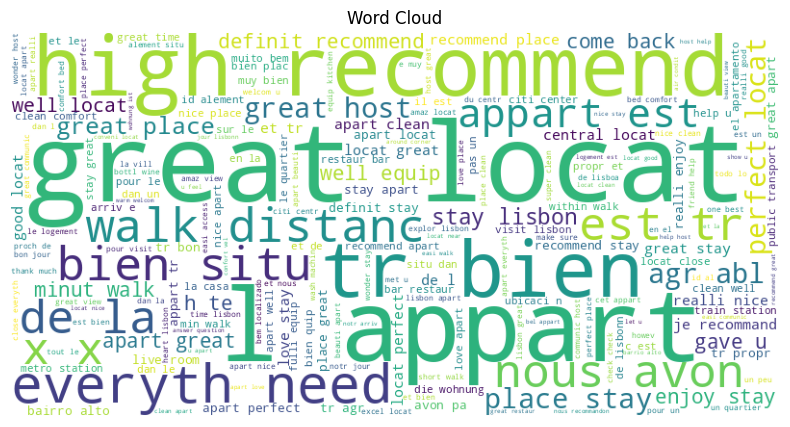

In [ ]:
# Word cloud of 'full_text' variable in train
all_description = ' '.join(train['full_text'])

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_description)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud')
plt.show()

<ipython-input-34-51804f2c7fa1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


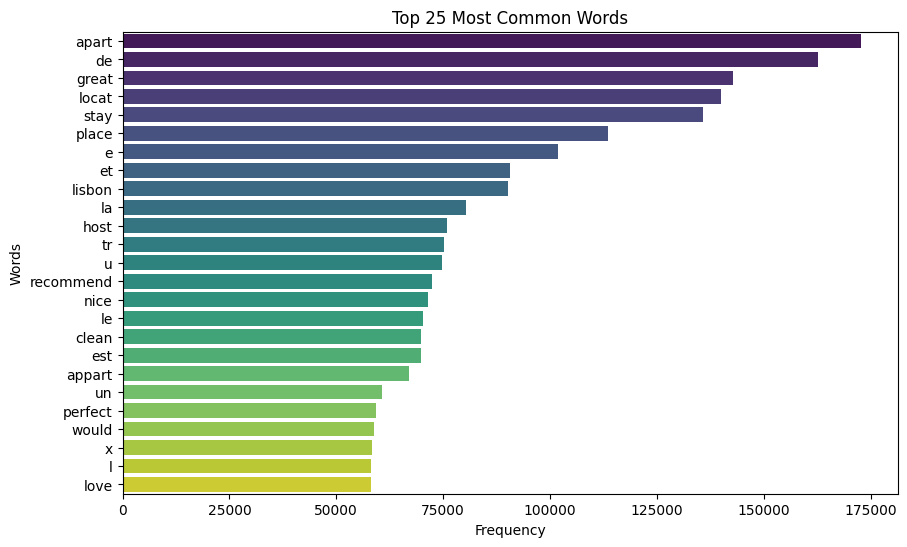

In [ ]:
# Barplot of top 25 words
def plot_top_n_words(corpus, n=25):
    words = [word for doc in corpus for word in doc.split()]
    word_freq = Counter(words)
    common_words = word_freq.most_common(n)
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=words, palette='viridis')
    plt.title(f'Top {n} Most Common Words')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

plot_top_n_words(train['full_text'])

<ipython-input-35-ecf17ad9acfb>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngrams_df, palette='viridis')


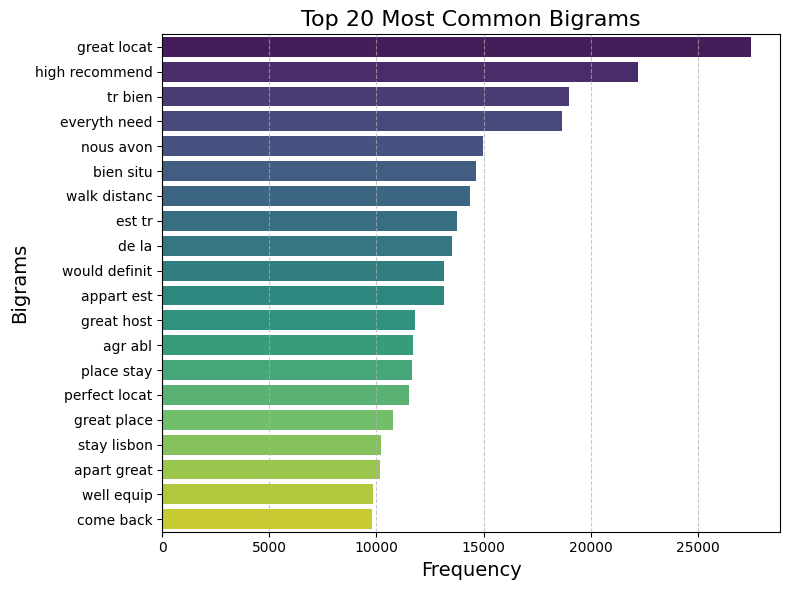

In [ ]:
# Barplot of 20 most common bigram (pairs of words)
def plot_bigrams(corpus, n=20):
    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=n)
    X = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    counts = X.toarray().sum(axis=0)

    ngrams_df = pd.DataFrame({'ngram': ngrams, 'count': counts})
    ngrams_df = ngrams_df.sort_values(by='count', ascending=False).head(n)

    plt.figure(figsize=(8, 6))
    sns.barplot(x='count', y='ngram', data=ngrams_df, palette='viridis')
    plt.title(f'Top {n} Most Common Bigrams', fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel('Bigrams', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_bigrams(train['full_text'], n=20)


## Feature Engineering

We implemented two methods in Feature Engineering, and after further inspection (model training with each) we concluded to TF-IDF.

### TF-IDF: identifying the most important words in the document

In [ ]:
# Feature Extraction with TF-IDF
tfidf = TfidfVectorizer(max_features=25)  # Adjust 'max_features' based on your computational resource
X_tfidf = tfidf.fit_transform(train['full_text'])

In [ ]:
# Convert X_tfidf to a dense array if it's sparse (to be ready for concat on following cell)
if isinstance(X_tfidf, scipy.sparse.csr.csr_matrix):
    X_tfidf_array = X_tfidf.toarray()

<ipython-input-37-cb80c35aef23>:2: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if isinstance(X_tfidf, scipy.sparse.csr.csr_matrix):


<ipython-input-38-37bbbca2d672>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_head['TF-IDF'], y=df_head.index, palette='viridis')


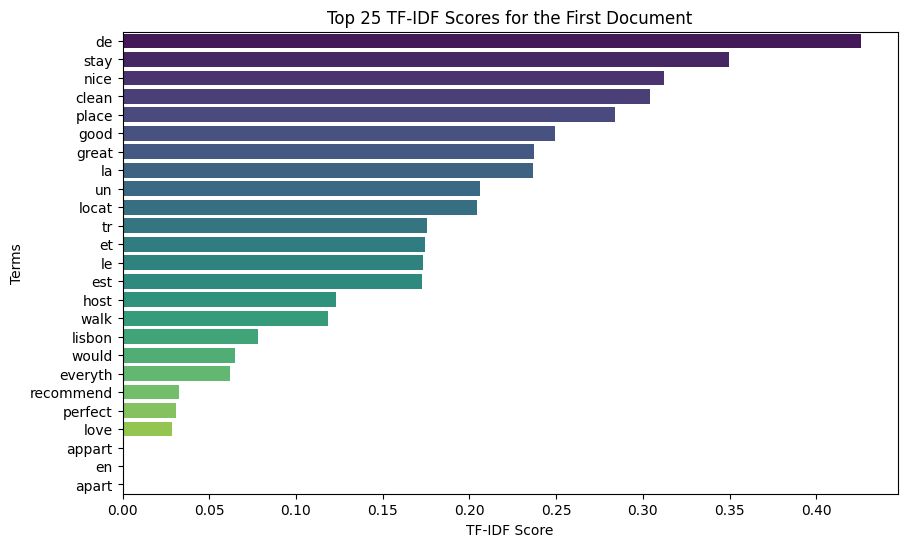

In [ ]:
# Barplot of 25 values with the highest TF-IDF scores
df = pd.DataFrame(X_tfidf[0].T.todense(), index=tfidf.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
df_head = df.head(25)

plt.figure(figsize=(10, 6))
sns.barplot(x=df_head['TF-IDF'], y=df_head.index, palette='viridis')
plt.title(f'Top 25 TF-IDF Scores for the First Document')
plt.xlabel('TF-IDF Score')
plt.ylabel('Terms')
plt.show()

### GloVe (Global Vectors) Word Embeddings

In [ ]:
!pip install torchtext==0.6.0
!pip install tqdm
!pip install keras-preprocessing

In [ ]:
import torch
import torchtext.vocab as vocab
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence

import tensorflow as tf
import tensorflow.keras as keras
from keras_preprocessing.sequence import pad_sequences

In [ ]:
glove = vocab.GloVe(name='6B', dim=50)
print('Loaded {} words'.format(len(glove.itos)))

.vector_cache/glove.6B.zip: 862MB [02:38, 5.43MB/s]                           
100%|█████████▉| 399999/400000 [00:22<00:00, 17658.53it/s]


Loaded 400000 words


In [ ]:
def get_word_vector(word):
    return glove.vectors[glove.stoi[word]]

def document_to_vectors(document):#, max_length):
    """
    Map each token to its word vector
    """
    word_vectors = []
    for token in document.split():
        if token in glove.stoi:
            word_vector = get_word_vector(token)
            word_vectors.append(word_vector)
    return pad_sequence([torch.tensor(vec) for vec in word_vectors], batch_first=True, padding_value=0)

def corpus_to_glove(corpus, max_length):
    """
    Aggregate word vectors for each doc
    """
    corpus_vectors = []
    for document in tqdm(corpus):
        doc_vectors = document_to_vectors(document)#, max_length)
        # Pad the sequences to max_length (we add zeros until max_length since sentences don't have same length)
        if len(doc_vectors) > 0:
            padded_vectors = pad_sequences([doc_vectors], maxlen=max_length, dtype='float32', padding='post', truncating='post', value=0.0)[0]
        else:
            padded_vectors = np.zeros((max_length, glove.dim))

        corpus_vectors.append(padded_vectors)
        #corpus_vectors.append(doc_vectors)
    return corpus_vectors

In [ ]:
X_glove = corpus_to_glove(train['full_text'], 25)

  0%|          | 0/6248 [00:00<?, ?it/s]<ipython-input-55-b3d03aa774f4>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return pad_sequence([torch.tensor(vec) for vec in word_vectors], batch_first=True, padding_value=0)
100%|██████████| 6248/6248 [03:58<00:00, 26.20it/s]


In [ ]:
X_glove_array = np.array(X_glove)

In [ ]:
# Flatten X_glove_array from 3-dimensions to 2-dim
X_glove_flattened = X_glove_array.reshape(X_glove_array.shape[0], -1)
print("Shape of X_glove_flattened: ", X_glove_flattened.shape)

Shape of X_glove_flattened:  (6248, 1250)


### Doc2Vec - not considered extra work, part of class material

In [ ]:
from gensim.models.doc2vec import Doc2Vec,\
	TaggedDocument
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
							tags=[str(i)]) for i,
			doc in enumerate(train['full_text'])]

# train the Doc2vec model
model = Doc2Vec(vector_size=25,
				min_count=2, epochs=50)
model.build_vocab(tagged_data)
model.train(tagged_data,
			total_examples=model.corpus_count,
			epochs=model.epochs)

# get the document vectors
X_d2v = [model.infer_vector(word_tokenize(doc.lower())) for doc in train['full_text']]

# print the document vectors for the first 5 documents
#for i, doc in enumerate(train['full_text'][:5]):
#    print("Document", i+1, ":", doc)
#    print("Vector:", X_d2v[i])
#    print()

In [ ]:
X_d2v_array = np.array(X_d2v)

### XLM_RoBERTa - EXTRA METHOD **wait**

In [25]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel, XLMRobertaForSequenceClassification
import torch

In [26]:
# Load tokenizer and model
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

encoded_inputs = []

# Tokenize and encode the text
for text in train['full_text']:
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    encoded_inputs.append(encoded_input)

In [ ]:
# Pass the encoded inputs through the model
with torch.no_grad():
    outputs = [model(**input) for input in encoded_inputs]

In [ ]:
# Get the output embeddings for each input
embeddings = [output.last_hidden_state.mean(dim=1) for output in outputs]

In [ ]:
X_xlmr = [embedding.numpy() for embedding in embeddings]

## Model Training

Implement and test three (3) of the classification algorithms seen in class: KNN, LR, MLP, LSTM, etc

### Data Splitting

In [ ]:
# Define target column
y = train['unlisted'].values
# Encoding labels if they are not already in binary format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf_array, y_encoded, test_size=0.2, random_state=42)


### Regression

In [ ]:
# Model Training
# Logistic Regression
start_time_regr = time.time()
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_val)
end_time_regr = time.time()
print("Logistic Regression Metrics:")
print(classification_report(y_val, lr_predictions))
print("\nTotal time for logistic regression to run:", round(end_time_regr-start_time_regr,2), "\n")

Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       905
           1       0.60      0.54      0.57       345

    accuracy                           0.77      1250
   macro avg       0.72      0.70      0.71      1250
weighted avg       0.77      0.77      0.77      1250


Total time for logistic regression to run: 0.14 



### Multilayer Perceptron (MLP)

In [ ]:
# MLP
start_time_mlp = time.time()
mlp_model = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=1)
mlp_model.fit(X_train, y_train)
mlp_predictions = mlp_model.predict(X_val)
end_time_mlp = time.time()
print("Multilayer Perceptron Metrics:")
print(classification_report(y_val, mlp_predictions))
print("\nTotal time for MLP to run:", round(end_time_mlp-start_time_mlp,2), "\n")

Multilayer Perceptron Metrics:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84       905
           1       0.58      0.78      0.66       345

    accuracy                           0.78      1250
   macro avg       0.74      0.78      0.75      1250
weighted avg       0.81      0.78      0.79      1250


Total time for MLP to run: 2.33 



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Random Forest

In [ ]:
# Random Forest with Grid Search
start_time_rf = time.time()
rf = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, n_jobs=1, verbose=2)
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_val)
end_time_rf = time.time()
print("Random Forest metrics:\n", classification_report(y_val, y_pred_rf))
print("\nTotal time for Random Forest to run:", round(end_time_rf-start_time_rf,2), "\n")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END max

### Support Vector Machine (SVM)

In [ ]:
# SVM with Grid Search
start_time_svm = time.time()
svm = SVC()
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, n_jobs=-1, verbose=2)
grid_search_svm.fit(X_train, y_train)

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_val)
end_time_svm = time.time()
print("Support Vector Machine metrics:\n", classification_report(y_val, y_pred_svm))
print("\nTotal time for SVM to run:", round(end_time_svm-start_time_svm,2), "\n")

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Support Vector Machine metrics:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       905
           1       0.69      0.79      0.73       345

    accuracy                           0.84      1250
   macro avg       0.80      0.83      0.81      1250
weighted avg       0.85      0.84      0.85      1250


Total time for SVM to run: 80.58 



### XGBoost

In [ ]:
# XGBoost with Grid Search
start_time_xgb = time.time()
xgb = XGBClassifier()
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_val)
end_time_xgb = time.time()
print("XGBoost metrics:\n", classification_report(y_val, y_pred_xgb))
print("\nTotal time for XGBoost to run:", round(end_time_xgb-start_time_xgb,2), "\n")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
XGBoost metrics:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       905
           1       0.70      0.70      0.70       345

    accuracy                           0.84      1250
   macro avg       0.79      0.79      0.79      1250
weighted avg       0.84      0.84      0.84      1250


Total time for XGBoost to run: 156.37 



### LSTM (Long Short-Term Memory)

In [ ]:
# Tokenize and pad sequences for LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train['full_text'])  # Changed from train_df to train

X_train_seq = tokenizer.texts_to_sequences(train['full_text'])  # Changed from train_df to train
X_val_seq = tokenizer.texts_to_sequences(test['full_text'])  # Changed from test_df to test

X_train_pad = pad_sequences(X_train_seq, maxlen=500)
X_val_pad = pad_sequences(X_val_seq, maxlen=500)

# Extract target variable
y_train = train['unlisted']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, random_state=42)

# LSTM Model
start_time_lstm = time.time()
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=500))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), verbose=2)

# Evaluate the model
y_pred_lstm = (model.predict(X_val) > 0.5).astype("int32")
end_time_lstm = time.time()
print("LSTM metrics:\n", classification_report(y_val, y_pred_lstm))
print("\nTotal time for LSTM to run:", round(end_time_lstm-start_time_lstm,2), "\n")

NameError: name 'Tokenizer' is not defined

### Neural Network

In [ ]:
# Neural Network
start_time_nn = time.time()
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=500))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=64)
nn_predictions = model.predict(X_val).round()
end_time_nn = time.time()
print("Neural Network Metrics:")
print(classification_report(y_val, nn_predictions))
print("\nTotal time for NN to run:", round(end_time_nn-start_time_nn,2), "\n")

Epoch 1/5
79/79 [==============================] - 5s 28ms/step - loss: 0.6155 - accuracy: 0.7109
Epoch 2/5
79/79 [==============================] - 2s 24ms/step - loss: 0.3699 - accuracy: 0.8409
Epoch 3/5
79/79 [==============================] - 1s 18ms/step - loss: 0.2249 - accuracy: 0.9316
Epoch 4/5
79/79 [==============================] - 2s 23ms/step - loss: 0.1313 - accuracy: 0.9720
Epoch 5/5
40/40 [==============================] - 1s 8ms/step
Neural Network Metrics:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       905
           1       0.52      0.34      0.41       345

    accuracy                           0.73      1250
   macro avg       0.65      0.61      0.62      1250
weighted avg       0.71      0.73      0.71      1250


Total time for NN to run: 14.65 



## Evaluation


Evaluate your models resorting, at least, to Recall, Precision, Accuracy and F1-Score.

>Point1: due to **imbalance** in the target, we prefer to evaluate by f1score than accuracy.<br> Moreover, we want high numbers in both precision and recall = low false positives and false negatives respectively.



>Point2: "weighted f1-score, it calculates the f1-score for each class and gets the weighted average using the proportion of each class in the dataset, whereas macro f1-score gets the arithmetic (unweighted) average. Macro f1-score is considered to be a robust metric for addressing class imbalance as it weights all classes equally, thereby penalizing the model when it performs poorly on the under-represented classes"

In [ ]:
# Example classification reports (replace these with actual classification report strings)
lr_report = classification_report(y_val, lr_predictions, output_dict=True)
mlp_report = classification_report(y_val, mlp_predictions, output_dict=True)
rf_report = classification_report(y_val, y_pred_rf, output_dict=True)
nn_report = classification_report(y_val, nn_predictions, output_dict=True)
svm_report = classification_report(y_val, y_pred_svm, output_dict=True)
xgb_report = classification_report(y_val, y_pred_xgb, output_dict=True)
lstm_report = classification_report(y_val, y_pred_lstm, output_dict=True)

# Runtimes
runtime_lr = end_time_regr - start_time_regr
runtime_mlp = end_time_mlp - start_time_mlp
runtime_rf = end_time_rf - start_time_rf
runtime_nn = end_time_nn - start_time_nn
runtime_svm = end_time_svm - start_time_svm
runtime_xgb = end_time_xgb - start_time_xgb
runtime_lstm = end_time_lstm - start_time_lstm

# Extract metrics for each model and add runtime
models_metrics = {
    "Logistic Regression": {**lr_report['weighted avg'], "runtime": runtime_lr},
    "MLP": {**mlp_report['weighted avg'], "runtime": runtime_mlp},
    "Random Forest": {**rf_report['weighted avg'], "runtime": runtime_rf},
    "SVM": {**svm_report['weighted avg'], "runtime": runtime_svm},
    "XGBoost": {**xgb_report['weighted avg'], "runtime": runtime_xgb},
    "LSTM": {**lstm_report['weighted avg'], "runtime": runtime_lstm},
    "Neural Network": {**nn_report['weighted avg'], "runtime": runtime_nn}
}

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame(models_metrics).T[['precision', 'recall', 'f1-score', 'support', 'runtime']]

print(metrics_df)

                     precision  recall  f1-score  support      runtime
Logistic Regression   0.659918  0.6784  0.667452   1250.0     2.365106
MLP                   0.661244  0.6744  0.666991   1250.0    13.817462
Random Forest         0.797643  0.7760  0.723084   1250.0  1294.301240
SVM                   0.856171  0.8488  0.851395   1250.0 -3313.588943
XGBoost               0.859968  0.8512  0.854113   1250.0 -5766.174478
LSTM                  0.862244  0.8616  0.861906   1250.0   757.485487
Neural Network        0.706936  0.7320  0.711458   1250.0    14.648279


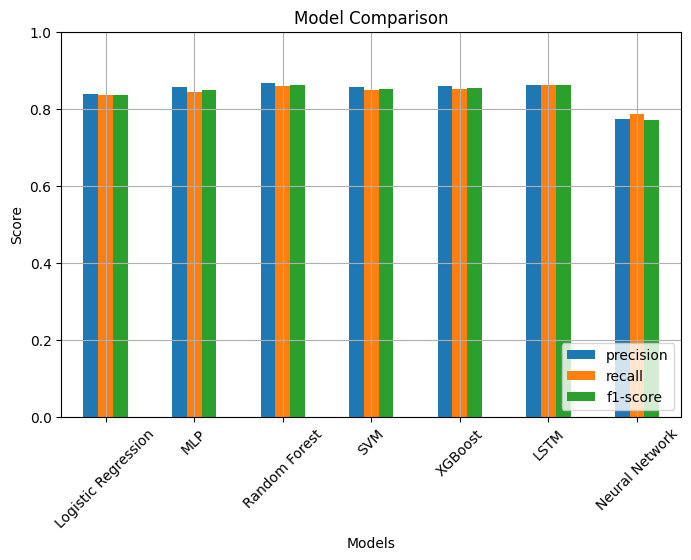

In [ ]:
# Plotting the comparison graph
metrics_df.drop(columns=['support','runtime'], inplace=True)  # Drop the support column for plotting

# Plot the metrics
metrics_df.plot(kind='bar', figsize=(8, 5))
plt.title("Model Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.ylim(0, 1)  # Scores range from 0 to 1
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Results of the three feature engineering methods

- TF-IDf

| Model               | Precision | Recall | F1-Score | Support | Runtime     |
|---------------------|-----------|--------|----------|---------|-------------|
| Logistic Regression | 0.838386  | 0.8360 | 0.837059 | 1250.0  | 0.066617    |
| MLP                 | 0.855511  | 0.8440 | 0.847615 | 1250.0  | 1.819831    |
| Random Forest       | 0.866244  | 0.8600 | 0.862203 | 1250.0  | 177.702947  |
| SVM                 | 0.856171  | 0.8488 | 0.851395 | 1250.0  | 20.108435   |
| XGBoost             | 0.859968  | 0.8512 | 0.854113 | 1250.0  | 104.333441  |
| LSTM                | 0.862244  | 0.8616 | 0.861906 | 1250.0  | 757.485487  |
| Neural Network      | 0.773195  | 0.7864 | 0.771077 | 1250.0  | 6.713358    |

<br>

- GloVe <br>(we could see that the results were worse already from the 3 first models, we skip running models that have huge runtime)


| Model               | Precision | Recall | F1-Score | Support | Runtime       |
|---------------------|-----------|--------|----------|---------|---------------|
| Logistic Regression | 0.659918  | 0.6784 | 0.667452 | 1250.0  | 2.365106      |
| MLP                 | 0.661244  | 0.6744 | 0.666991 | 1250.0  | 13.817462     |
| Random Forest       | 0.797643  | 0.7760 | 0.723084 | 1250.0  | 1294.301240   |
| SVM                 | -         | -      | -        | -       | -           |
| XGBoost             | -         | -      | -        | -       | -           |
| LSTM                | -         | -      | -        | -       | -           |
| Neural Network      | 0.706936  | 0.7320 | 0.711458 | 1250.0  | 14.648279     |

<br>

- Dov2Vec (disconnected)


| Model               | Precision | Recall | F1-Score | Support | Runtime       |
|---------------------|-----------|--------|----------|---------|---------------|
| Logistic Regression | 0.77  | 0.77 | 0.77 | 1250.0  | 0.14     |
| MLP                 | 0.81  | 0.78 | 0.79 | 1250.0  | 2.33     |
| Random Forest       | 0.83  | 0.84 | 0.83 | 1250.0  | 214.19   |
| SVM                 | 0.85  | 0.84 | 0.85 | 1250.0  | 80.58    |
| XGBoost             | 0.84  | 0.84 | 0.84 | 1250.0  | 156.37   |
| LSTM                | -  | - | - | -  | -     |
| Neural Network      | -  | - | - | -  | -     |

## Final

- Chosen Feature Eng method: **wait for RoBERTa, otherwise** TF-IDF
- Chose Model for predictions: **waiting for RoBERTa**

In [ ]:
# Preparing the Test Data for Final Prediction
X_test = tfidf.transform(test['full_text']).toarray()
test_predictions = lr_model.predict(X_test)

In [ ]:
# Creating a CSV for submission
test_ids = test['index']  # Assure this is the correct identifier column
submission_df = pd.DataFrame({'id': test_ids, 'predicted': test_predictions})
submission_df.to_csv('/mnt/data/Predictions_XX.csv', index=False)  # Adjust filename as necessary
print("Submission file created successfully.")